# Issue 11

In [5]:
from persist.archive import Archive
x = [1, 2, 3]
y = [x, x]
a = Archive(scoped=False)
a.insert(y=y)
s = str(a)
d = {}
exec(s, d)
y_ = d['y']
assert y[0] is y[1]
assert y_[0] is y_[1]

AssertionError: 

After a bit of inspection, I found that the problem occurs at the reduction state.  The call to `Graph.reduce()` is a bit too eager.  Need to find out why.  (Found a few bugs in the constructors for `Graph` and `Graph_` which should be similar...)


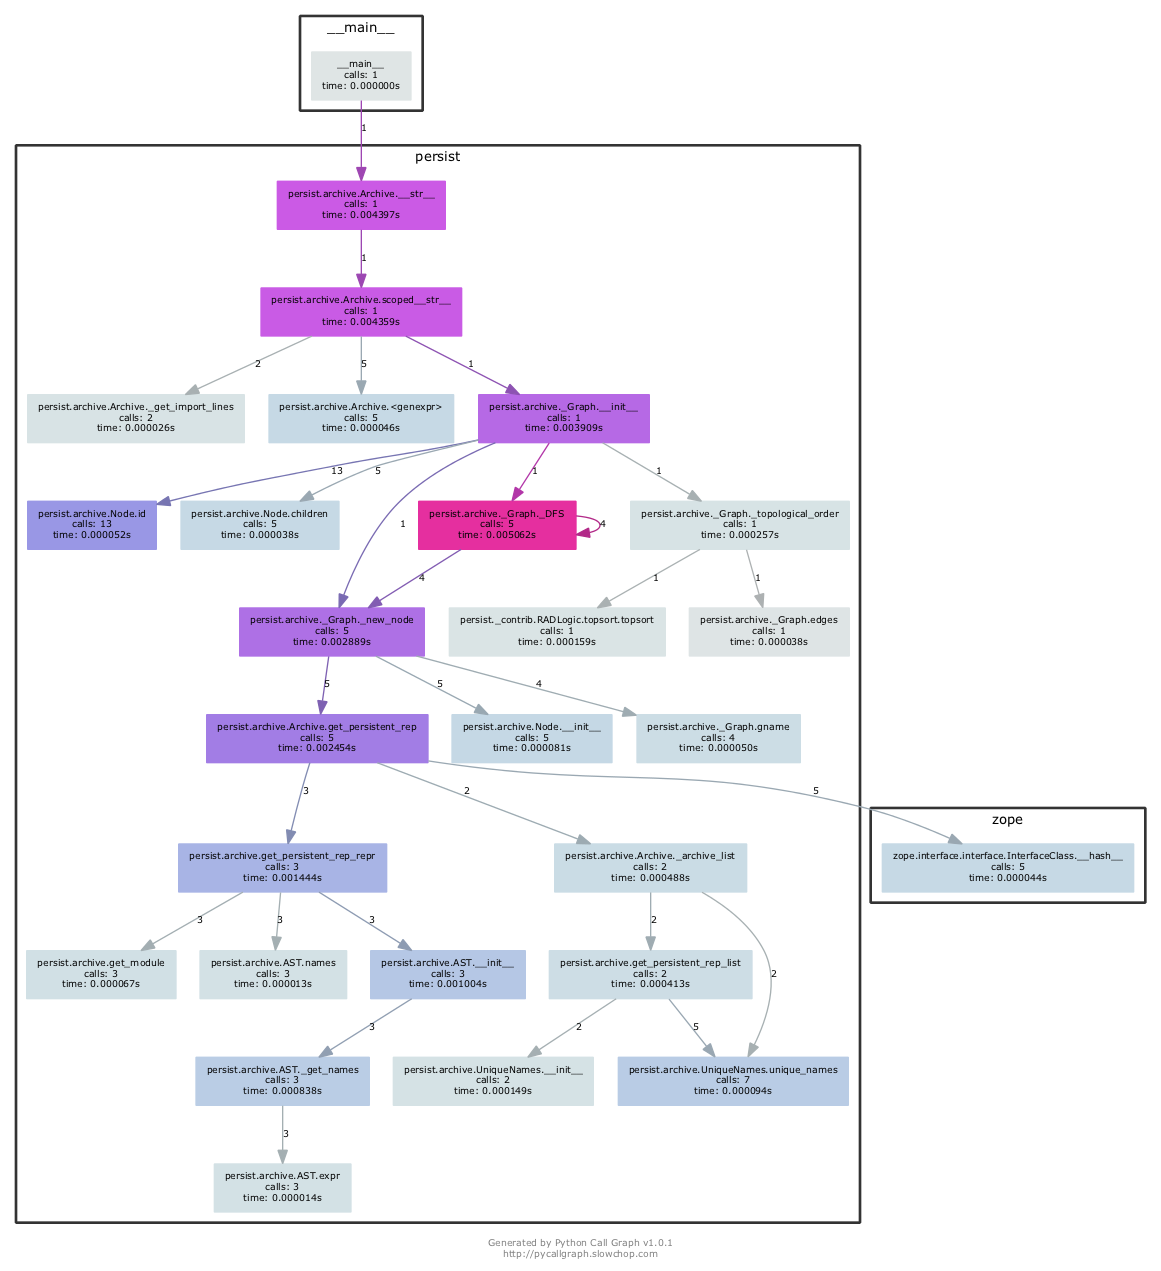

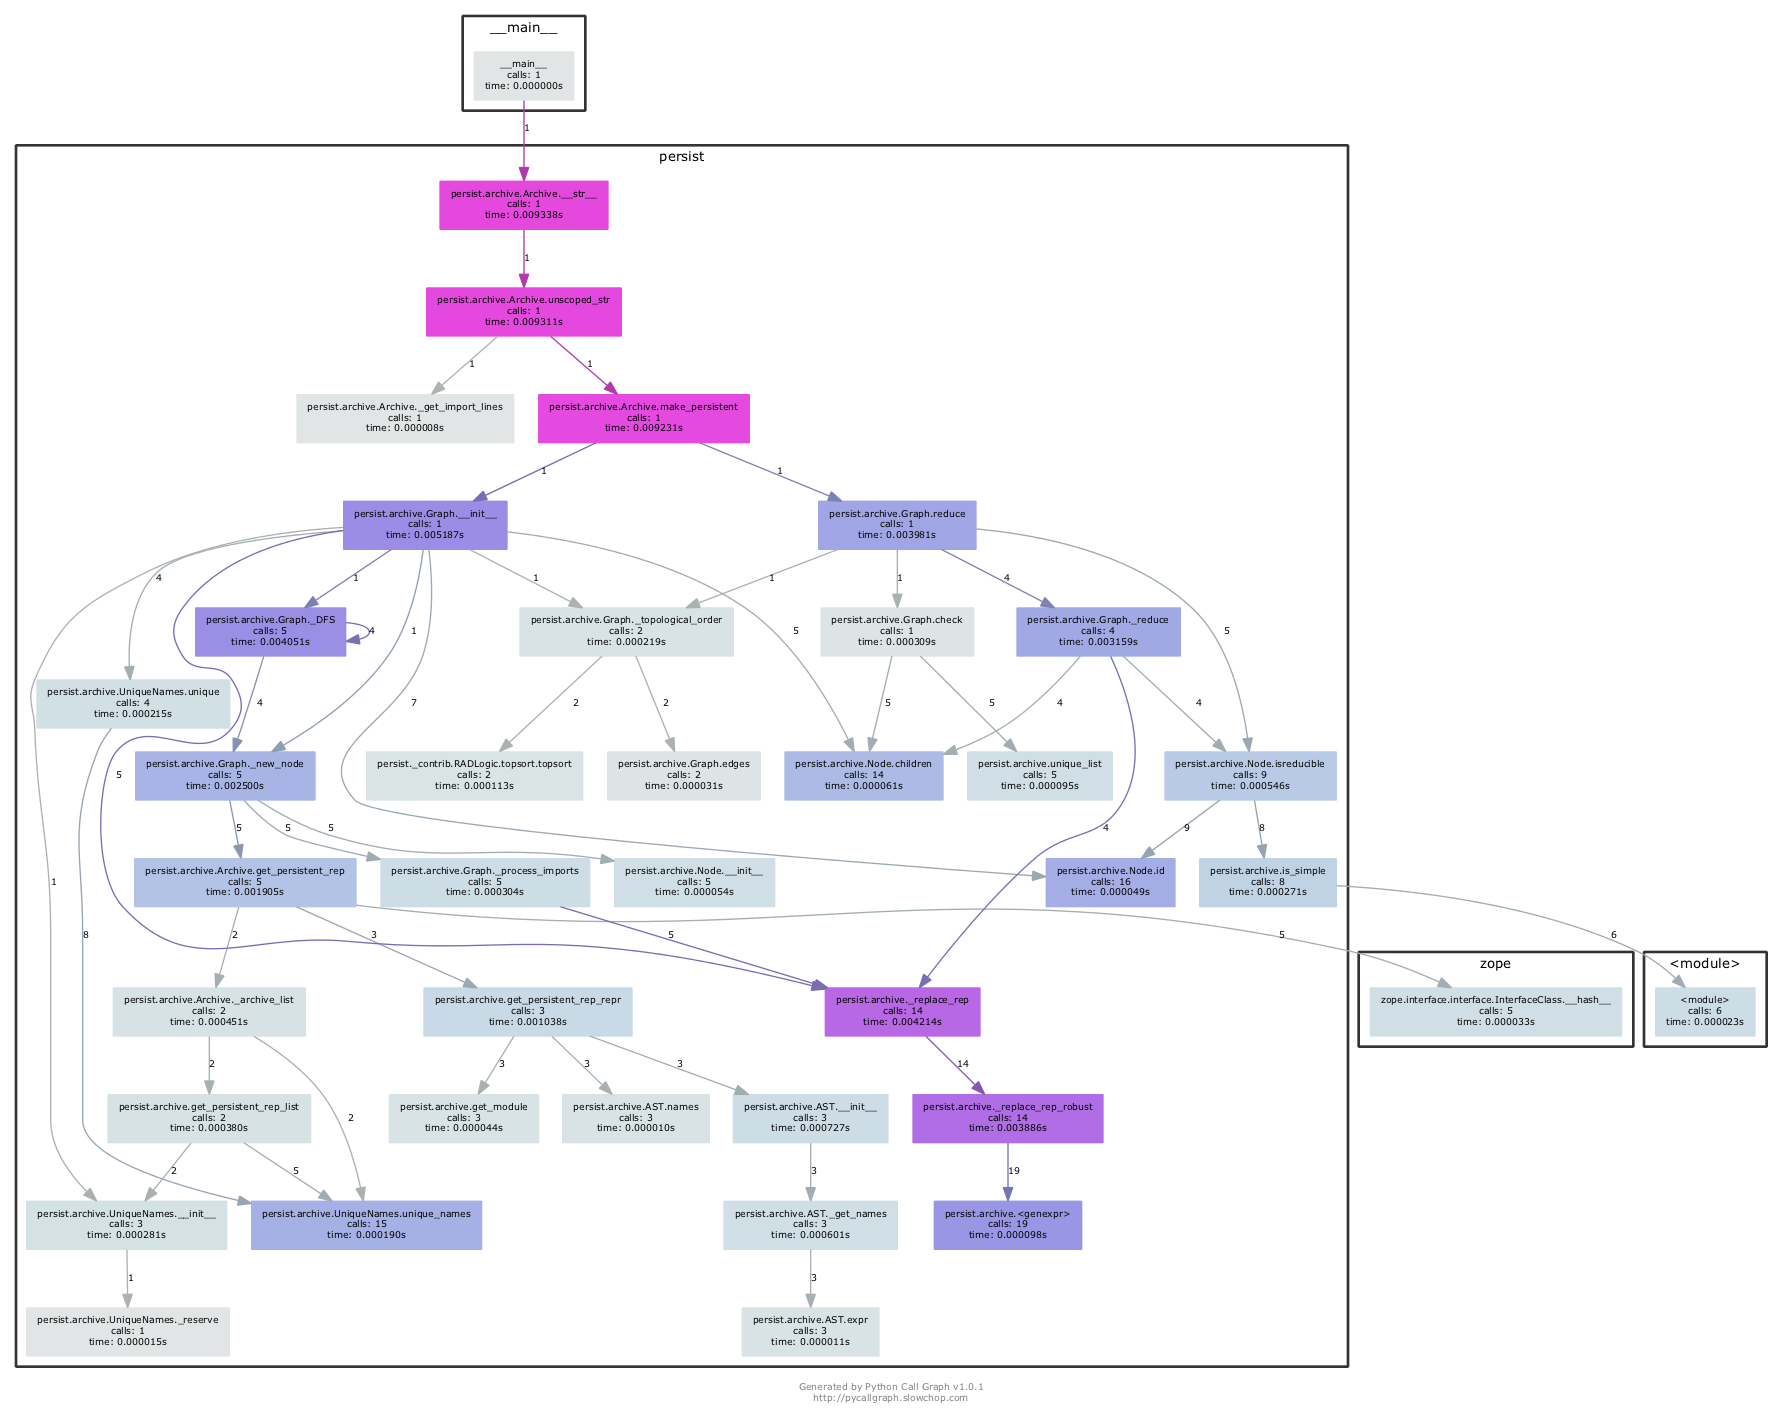

In [7]:
from IPython.display import Image, display
import os
import sys
import trace

from persist.archive import Archive
x = [1, 2, 3]
y = [x, x]

from pycallgraph import PyCallGraph
from pycallgraph.output import GraphvizOutput

images = []

a = Archive(scoped=True)
a.insert(y=y)
with PyCallGraph(output=GraphvizOutput()):
    s = str(a)
images.append(Image(filename='pycallgraph.png', width="20%"))
os.remove('pycallgraph.png')

a = Archive(scoped=False)
a.insert(y=y)
with PyCallGraph(output=GraphvizOutput()):
    s = str(a)
images.append(Image(filename='pycallgraph.png', width="20%"))    
os.remove('pycallgraph.png')

display(*images)

In [10]:
g = a._graph
g.nodes

{4573529008: Node(obj=[[1, 2, 3], [1, 2, 3]], rep='[[1, 2, 3], [1, 2, 3]]', args={}, name='y', imports=None, parents=set([]))}

In [7]:
# create a Trace object, telling it what to ignore, and whether to
# do tracing or line-counting or both.
tracer = trace.Trace(
    ignoredirs=[sys.prefix, sys.exec_prefix],
    trace=1,
    count=1)

# run the new command using the given tracer
tracer.run('str(a)')

# make a report, placing output in the current directory
r = tracer.results()
#r.write_results(show_missing=True, coverdir=".")

 --- modulename: archive, funcname: __str__
archive.py(1125):         if self.scoped:
archive.py(1128):             return self.unscoped_str()
 --- modulename: archive, funcname: unscoped_str
archive.py(1133):         imports, defs = self.make_persistent()
 --- modulename: archive, funcname: make_persistent
archive.py(1060):         try:
archive.py(1061):             graph = Graph(objects=self.arch,
archive.py(1062):                           get_persistent_rep=self.get_persistent_rep,
archive.py(1063):                           robust_replace=self.robust_replace)
 --- modulename: archive, funcname: __init__
archive.py(1608):         self.nodes = {}
archive.py(1609):         self.roots = set()
archive.py(1610):         self.envs = {}
archive.py(1611):         self.imports = []
archive.py(1612):         self.names = UniqueNames(set([name for (name, obj, env)
archive.py(1613):                                       in objects]))
archive.py(1613):                                       in o

The question here is who is responsible for ensuring that objects are not duplicated?
* The method `get_persistent_rep_list()` uses two names... so not here (but still has the same object).
